In [76]:
# Memeriksa Instalasi tensorFlow
!pip show tensorflow

print('\u2022 Using TensorFlow Version:', tf.__version__)

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow_decision_forests, tensorflowjs, tf_keras
• Using TensorFlow Version: 2.18.0


In [77]:
# Memeriksa Instalasi tensorFlow
!pip show tensorflowjs

Name: tensorflowjs
Version: 4.22.0
Summary: 
Home-page: https://js.tensorflow.org/
Author: Google LLC
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: flax, importlib_resources, jax, jaxlib, packaging, six, tensorflow, tensorflow-decision-forests, tensorflow-hub, tf-keras
Required-by: 


In [3]:
# Menginstal TensorFlow (jika tidak Ada)
!pip install tensorflow

In [4]:
# Menginstal TensorFlowjs (jika tidak Ada)
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 70.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

# **Preprocessing**

In [78]:
# Mingimpor Pustaka
from google.colab import drive

import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import zipfile
import matplotlib.pyplot as plt

Memuat Data

In [79]:
# Mengatur lokasi path file yang dipakai di google drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/Shareddrives')

Mounted at /content/drive


In [7]:
!cp -r /content/drive/Shareddrives/BANGKIT/garbage_classification /content/dataset/

In [80]:
# Menyimpan lokasi direktori dataset di Google Drive
dataset_path = '/content/dataset'

In [81]:
# Memuat dataset gambar 'sampah' dari google drive
# Membagi dataset gambar 'sampah' menjadi data training dan validasi
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2, # memisahkan 20% data untuk validasi
    subset="training",
    seed=123,
    image_size=(128, 128), # menetapkan ukuran gambar yang konsisten
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2, # memisahkan 20% data untuk validasi
    subset="validation",
    seed=123,
    image_size=(128, 128), # menetapkan ukuran gambar yang konsisten
    batch_size=32
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


Normalisasi Data

In [82]:
# menghindari nilai piksel yang besar
normalization_layer = layers.Rescaling(1./255)

Augmentasi Data

In [83]:
# Melakukan augmentasi data pada dataset training
# Menerapkan normalisasi pada dataset training dan validasi.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),

])

train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Optimasi dengan Prefetching, caching, shuffling

In [84]:
# Meningkatkan efisiensi pemrosesan data menggunakan caching, shuffling, dan prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds.take(1):
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", labels_batch.shape)

Image batch shape:  (32, 128, 128, 3)
Label batch shape:  (32,)


Visualisasi Data

*   Run kembali untuk melihat output yang lain

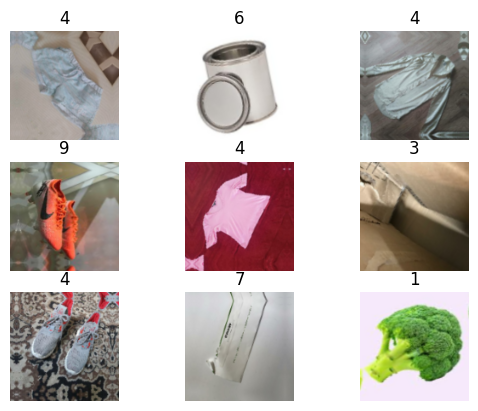

In [85]:
# Menampilkan contoh gambar dari batch data training
for image_batch, label_batch in train_ds.take(1):
  plt.figure(figure=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy())
    plt.title(int(label_batch[i]))
    plt.axis("off")
  plt.show()

# **Model**


In [86]:
# Menampilkan jumlah GPU yang tersedia
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Path ke dataset
dataset_path = '/content/dataset'

# Inisialisasi Dataset Training dan Validasi
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

# Menentukan Jumlah Kelas
num_classes = len(train_ds.class_names)

# Mendefinisikan Model CNN
def create_model():
    inputs = layers.Input(shape=(128, 128, 3))
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = False

    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Num GPUs Available:  1
Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,123,532 (92.02 MB)

 Trainable params: 531,724 (2.03 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

Compile Model

In [87]:
# Menampilkan model
model = create_model()

# Aktifkan fine-tuning
base_model = model.layers[1]
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Re-compile model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Menentukan Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/best_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

# Menentukan Parameter Pelatihan
num_train_samples = 12412
num_val_samples = 3103

batch_size = 32
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_val_samples // batch_size

train_ds = train_ds.repeat()
val_ds = val_ds.repeat()

# Melatih model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.3384 - loss: 2.3199 - val_accuracy: 0.7760 - val_loss: 0.7890 - learning_rate: 1.0000e-04
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.7455 - loss: 0.8338 - val_accuracy: 0.8365 - val_loss: 0.5706 - learning_rate: 1.0000e-04
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.8233 - loss: 0.5759 - val_accuracy: 0.8613 - val_loss: 0.4866 - learning_rate: 1.0000e-04
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.8568 - loss: 0.4679 - val_accuracy: 0.8769 - val_loss: 0.4261 - learning_rate: 1.0000e-04
Epoch 5/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.8890 - loss: 0.3693 - val_accuracy: 0.8857 - val_loss: 0.3913 - learning_rate: 1.0000e-04
Epoch 6/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9045 - loss: 0.3076 - val_accuracy: 0.8916 - val_loss: 0.3766 - learning_rate: 1.0000e-04
Epoch 7/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/ste

In [88]:
# Cetak Akurasi Model
test_loss, test_acc = model.evaluate(val_ds, steps=5000)
print(f"Test accuracy: {test_acc}")


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 176s 35ms/step - accuracy: 0.9134 - loss: 0.3020
Test accuracy: 0.9138350486755371


Grafik akurasi training dan validasi

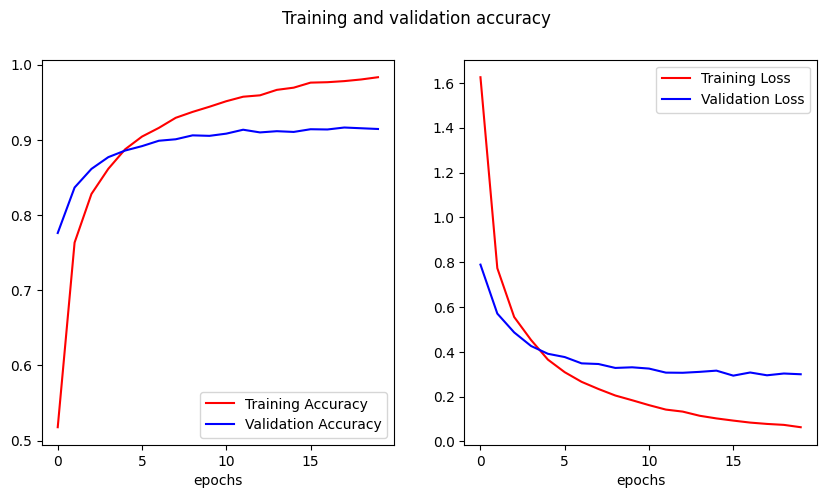

In [89]:
# Memuat data training dan validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# memuat jumlah epoch
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

Save Model ke dalam TensorFlowjs

In [95]:
model.save("/content/saved_model/my_model.keras")

In [96]:
from tensorflow.keras.models import load_model

model = load_model("/content/saved_model/my_model.keras")
print("Model loaded successfully!")

Model loaded successfully!


In [97]:
!tensorflowjs_converter --input_format keras \
                       /content/saved_model/my_model.keras \
                       /content/saved_model/tfjs_model

2024-11-16 01:44:56.162278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731721496.182463   33092 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731721496.188587   33092 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-package

In [98]:
!zip -r /content/tfjs_model.zip /content/saved_model/tfjs_model

  adding: content/saved_model/tfjs_model/ (stored 0%)
  adding: content/saved_model/tfjs_model/group1-shard22of24.bin (deflated 7%)
  adding: content/saved_model/tfjs_model/group1-shard2of24.bin (deflated 7%)
  adding: content/saved_model/tfjs_model/group1-shard17of24.bin (deflated 7%)
  adding: content/saved_model/tfjs_model/group1-shard20of24.bin (deflated 7%)
  adding: content/saved_model/tfjs_model/group1-shard14of24.bin (deflated 7%)
  adding: content/saved_model/tfjs_model/group1-shard10of24.bin (deflated 7%)
  adding: content/saved_model/tfjs_model/group1-shard23of24.bin (deflated 7%)
  adding: content/saved_model/tfjs_model/group1-shard16of24.bin (deflated 7%)
  adding: content/saved_model/tfjs_model/group1-shard21of24.bin (deflated 7%)
  adding: content/saved_model/tfjs_model/group1-shard12of24.bin (deflated 7%)
  adding: content/saved_model/tfjs_model/group1-shard3of24.bin (deflated 7%)
  adding: content/saved_model/tfjs_model/group1-shard5of24.bin (deflated 7%)
  adding: con

In [99]:
from google.colab import files
files.download('/content/tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>